In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# Load from Delta
tesla_sdf = spark.read.format("delta").load("/mnt/data/tesla_eda")

# Convert back to pandas if needed
tesla_eda_df = tesla_sdf.toPandas()
print(tesla_eda_df)

       _c0       Date       Open       High        Low      Close     Volume
0        0 2010-06-29   1.266667   1.666667   1.169333   1.592667  281494500
1        1 2010-06-30   1.719333   2.028000   1.553333   1.588667  257806500
2        2 2010-07-01   1.666667   1.728000   1.351333   1.464000  123282000
3        3 2010-07-02   1.533333   1.540000   1.247333   1.280000   77097000
4        4 2010-07-06   1.333333   1.333333   1.055333   1.074000  103003500
...    ...        ...        ...        ...        ...        ...        ...
3529  1762 2017-06-28  24.445333  24.782667  24.167999  24.749332   94537500
3530  1763 2017-06-29  24.707333  24.733334  23.606667  24.049999  123315000
3531  1764 2017-06-30  24.247334  24.451332  23.974667  24.107332   87727500
3532  1765 2017-07-03  24.682667  24.756666  23.433332  23.507999   94581000
3533  1766 2017-07-05  23.146667  23.149332  21.755333  21.806000  255700500

[3534 rows x 7 columns]


In [0]:
# Ensure 'Date' column is datetime type and sort by date to preserve time order
tesla_eda_df['Date'] = pd.to_datetime(tesla_eda_df['Date'])
tesla_eda_df = tesla_eda_df.sort_values('Date').reset_index(drop=True)

### What is the Target?
We define a binary classification target:
- `1`: if the next day's closing price is higher than today’s
- `0`: if it stays the same or goes down

This simple formulation sets us up to build a **binary classifier** predicting whether the stock will go up the next day — useful for traders or signal generation models.

In [0]:
# Create Target Variable: 1 if the next day's closing price is higher than today's, else 0
tesla_eda_df['Target'] = (tesla_eda_df['Close'].shift(-1) > tesla_eda_df['Close']).astype(int)

### Why Daily Return?
This measures the percentage change in price from the previous close. It captures **momentum** and **volatility** trends, both of which are vital in stock prediction.


In [0]:
# Calculate Daily Return: percentage change of the closing price day-over-day
tesla_eda_df['Daily_Return'] = tesla_eda_df['Close'].pct_change()

### What are Lag Features?
- `Close_Lag1`: Yesterday’s closing price
- `Volume_Lag1`: Yesterday’s volume

These help capture **temporal dependencies** — whether yesterday’s price or trading volume influence today’s market movement.


In [0]:
# Create Lag Features: previous day's closing price and volume
tesla_eda_df['Close_Lag1'] = tesla_eda_df['Close'].shift(1)
tesla_eda_df['Volume_Lag1'] = tesla_eda_df['Volume'].shift(1)

### Why Moving Averages?
Moving averages smooth out price noise and highlight trends. 
- Short windows (like 3) respond to **recent changes**.
- Longer windows (like 10) show **underlying trends**.

They help the model learn if a stock is riding an upward/downward wave — which can hint at continuation or reversal.

In [0]:
# Create Rolling Mean Features to capture short-term trends (3, 5, 10 days)
tesla_eda_df['Close_MA3'] = tesla_eda_df['Close'].rolling(window=3).mean()
tesla_eda_df['Close_MA5'] = tesla_eda_df['Close'].rolling(window=5).mean()
tesla_eda_df['Close_MA10'] = tesla_eda_df['Close'].rolling(window=10).mean()

### Why Volatility?
Volatility measures the **degree of price variation** over a period. High volatility may indicate uncertainty or major movement — useful for risk-sensitive models.


In [0]:

# Calculate Volatility: rolling standard deviation over 5 days to measure price fluctuation
tesla_eda_df['Volatility_5'] = tesla_eda_df['Close'].rolling(window=5).std()

### What do these ratios show?
- `HL_Pct`: How wide the high-low range is for a day.
- `CO_Pct`: How far the price moved between open and close.

These reflect **intraday volatility and momentum**, useful for identifying bullish or bearish sentiment in a single day.


In [0]:
# Create Price Ratio Features: measures of intraday price range and change
tesla_eda_df['HL_Pct'] = (tesla_eda_df['High'] - tesla_eda_df['Low']) / tesla_eda_df['Low'] * 100  # High-Low percentage range
tesla_eda_df['CO_Pct'] = (tesla_eda_df['Close'] - tesla_eda_df['Open']) / tesla_eda_df['Open'] * 100  # Close-Open percentage change

### What is RSI and why include it?
The Relative Strength Index is a **momentum oscillator**. It compares recent gains to losses to estimate **overbought or oversold** conditions.
- RSI > 70: Overbought → price might fall
- RSI < 30: Oversold → price might rise

It gives models a **technical signal** based on market psychology and trading momentum.

In [0]:
# Calculate RSI (Relative Strength Index) over 14 days — a popular momentum indicator
delta = tesla_eda_df['Close'].diff()
gain = delta.where(delta > 0, 0.0)
loss = -delta.where(delta < 0, 0.0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain / avg_loss
tesla_eda_df['RSI_14'] = 100.0 - (100.0 / (1.0 + rs))

In [0]:
# Drop rows with NA values caused by rolling calculations and shifting
tesla_featured = tesla_eda_df.dropna().reset_index(drop=True)

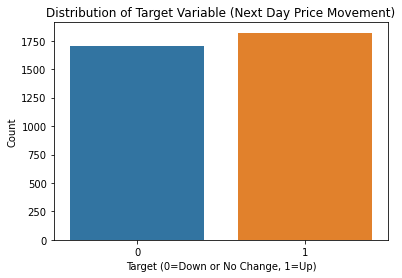

In [0]:
# Distribution of Target Variable
plt.figure(figsize=(6,4))
sns.countplot(x='Target', data=tesla_featured)
plt.title('Distribution of Target Variable (Next Day Price Movement)')
plt.xlabel('Target (0=Down or No Change, 1=Up)')
plt.ylabel('Count')
plt.show()


This plot shows how often Tesla's stock price increases the next day versus it staying the same or decreasing.
The distribution looks fairly balanced, which is beneficial for training predictive models without bias.

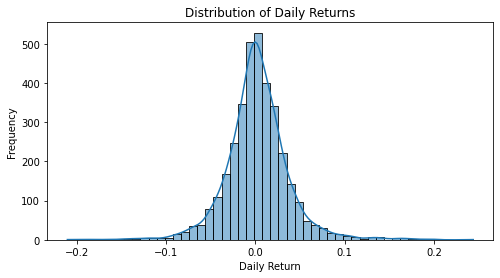

In [0]:
# Histogram of Daily Returns
plt.figure(figsize=(8,4))
sns.histplot(tesla_featured['Daily_Return'], bins=50, kde=True)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()


Daily returns are centered around zero, indicating price fluctuations in both directions.
The distribution reflects typical market behavior where small gains and losses happen frequently.

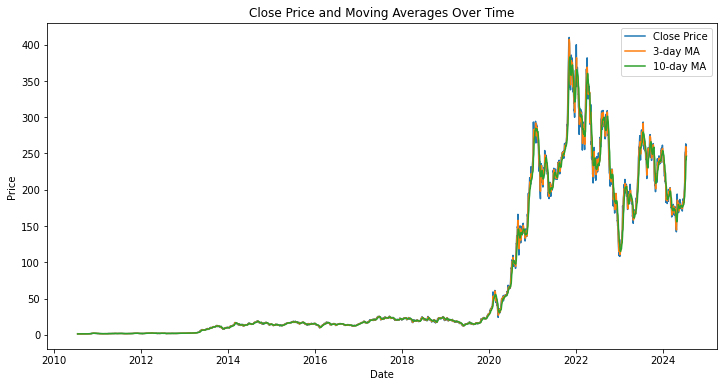

In [0]:
# Time Series Plot of Close Price & Moving Averages
plt.figure(figsize=(12,6))
plt.plot(tesla_featured['Date'], tesla_featured['Close'], label='Close Price')
plt.plot(tesla_featured['Date'], tesla_featured['Close_MA3'], label='3-day MA')
plt.plot(tesla_featured['Date'], tesla_featured['Close_MA10'], label='10-day MA')
plt.title('Close Price and Moving Averages Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


Moving averages smooth out short-term price noise and highlight trends.
The 3-day moving average reacts faster to price changes than the 10-day moving average.

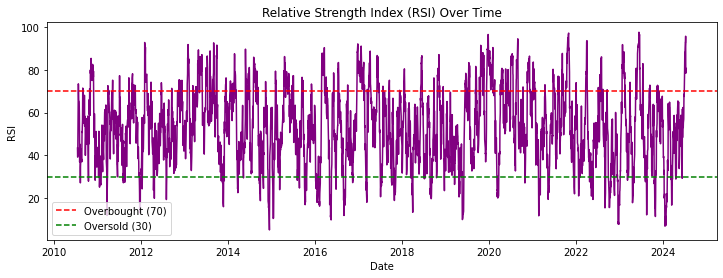

In [0]:
# RSI Over Time
plt.figure(figsize=(12,4))
plt.plot(tesla_featured['Date'], tesla_featured['RSI_14'], color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title('Relative Strength Index (RSI) Over Time')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.show()

RSI values above 70 indicate overbought conditions (possible price drop),
and values below 30 indicate oversold conditions (possible price rise).
This momentum indicator can help identify turning points in the stock price.

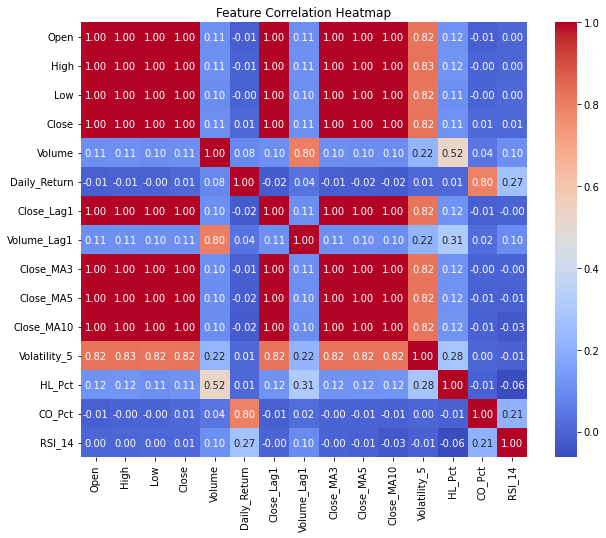

In [0]:
# Correlation Heatmap of Features

plt.figure(figsize=(10,8))
corr = tesla_featured.drop(columns=['Date', 'Target']).corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


This heatmap shows relationships between features.
Strong correlations suggest some features may be redundant,
which can inform feature selection or dimensionality reduction later.

In [0]:
# Convert back to Spark DataFrame for further processing/modeling if needed
tesla_featured_spark = spark.createDataFrame(tesla_featured)

# Save the engineered dataset for the modeling notebook

# Option 1: Save as a Delta Table (recommended for Databricks workflow)
tesla_featured_spark.write.mode("overwrite").format("delta").saveAsTable("tesla_stock_features")